<a href="https://colab.research.google.com/github/AyusmaTech/DogBreedClassifier/blob/main/DogBreedClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from collections import OrderedDict
import numpy as np
import pandas as pd
from PIL import Image
!pip install -q wget
import wget
import shutil 
import tarfile
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Downlaod dataset to Gdrive
url = 'http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar'
wget.download(url, '/content/drive/My Drive/DogImages')

In [ ]:
url = 'http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar'
wget.download(url, '/content/drive/My Drive/DogAnnotation')

'/content/drive/My Drive/DogAnnotation'

In [ ]:
my_tar = tarfile.open('/content/drive/My Drive/DogAnnotation')
my_tar.extractall('/content/DogImages_DogAnnotation') 
my_tar.close()

In [ ]:
my_tar = tarfile.open('/content/drive/My Drive/DogImages')
my_tar.extractall('/content/DogImages_Datatset') 
my_tar.close()

In [ ]:
data_dir = '/content'
train_dir = data_dir + '/Training'
validation_dir = data_dir + '/Validation'
test_dir = data_dir + '/Test'

os.mkdir(train_dir)
os.mkdir(validation_dir)
os.mkdir(test_dir)


In [ ]:
breeds = os.listdir('/content/DogImages_Datatset/Images')  

for x in breeds:
  size = len(os.listdir('/content/DogImages_Datatset/Images/'+x))
  train = size * 0.8
  valid = (size - round(train))/2
  test = (size - round(train)) -round(valid)
 # print(round(train),round(valid),test,size)
  jpegnames = os.listdir('/content/DogImages_Datatset/Images/'+x) 
  dir_train = train_dir+"/"+x
  dir_validation = validation_dir+"/"+x
  dir_test = test_dir+"/"+x
  os.mkdir(dir_train)
  os.mkdir(dir_validation)
  os.mkdir(dir_test)
  for i in range(size):
    if i < round(train): 
      shutil.move('/content/DogImages_Datatset/Images/'+x+'/'+jpegnames[i],train_dir+"/"+x) 
    elif i > round(train) and i <= round(train)+round(valid):
         shutil.move('/content/DogImages_Datatset/Images/'+x+'/'+jpegnames[i],validation_dir+"/"+x)  
    else:
      shutil.move('/content/DogImages_Datatset/Images/'+x+'/'+jpegnames[i],test_dir+"/"+x ) 
          
  #print(allocated_train,allocated_valid,allocated_test)



In [ ]:
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.CenterCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])


train_datasets = datasets.ImageFolder(train_dir,transform = train_transforms) 
validation_datasets = datasets.ImageFolder(validation_dir,transform = test_transforms) 
test_datasets = datasets.ImageFolder(test_dir,transform = test_transforms) 



train_dataloader = torch.utils.data.DataLoader(train_datasets,batch_size=64,shuffle=True)
validation_dataloader = torch.utils.data.DataLoader(validation_datasets,batch_size=64,shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_datasets,batch_size=64,shuffle=True)

In [ ]:

def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

In [ ]:

def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    im = Image.open(image)
    im.resize((256,256))
    processed_image = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406],
                                            [0.229, 0.224, 0.225])])
    return processed_image(im)
    

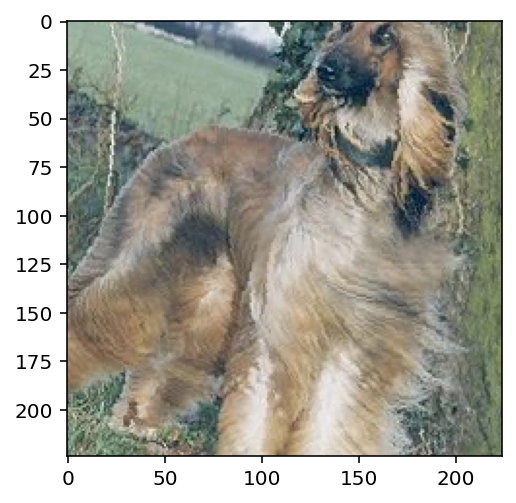

In [ ]:
image = iter(train_dataloader)
imshow(next(image)[0][0])

In [ ]:
model = models.resnet50(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
criterion = nn.NLLLoss()

In [ ]:
for param in model.parameters():
    param.requires_grad = False

model.fc  = nn.Sequential(OrderedDict([
                          ('dropout',nn.Dropout(0.5)),
                          ('fc1',nn.Linear(2048,480)),
                          ('relu',nn.ReLU()),
                          ('fc2',nn.Linear(480,80)),
                          ('relu2',nn.ReLU()),
                          ('fc3',nn.Linear(80,240)),
                          ('relu3',nn.ReLU()),
                          ('fc4',nn.Linear(240,120)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

optimizer = optim.Adam(model.fc.parameters(),lr=0.001)

criterion = nn.NLLLoss()


model.to(device)
model.class_to_idx = train_datasets.class_to_idx

In [ ]:
epochs = 15
steps = 0
running_loss = 0
# running_losses = 0
print_every = 5
 
for epoch in range(epochs):
    for images, labels in train_dataloader:
        steps += 1
        
        
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(images)
        loss = criterion(logps,labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        # running_losses += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for images, labels in validation_dataloader:
                    images, labels = images.to(device), labels.to(device)
                    logps = model.forward(images)
                    batch_loss = criterion(logps,labels)
                    test_loss += batch_loss.item() 
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
 
            
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Validation loss: {test_loss/len(validation_dataloader):.3f}.. "
                  f"Vaildation accuracy: {accuracy/len(validation_dataloader):.3f}")
            
            running_loss = 0
            model.train()
            if steps % 200 == 0:
                save()

Epoch 1/15.. Train loss: 0.724.. Validation loss: 0.626.. Vaildation accuracy: 0.798
Epoch 1/15.. Train loss: 0.919.. Validation loss: 0.649.. Vaildation accuracy: 0.786
Epoch 1/15.. Train loss: 0.847.. Validation loss: 0.680.. Vaildation accuracy: 0.775
Epoch 1/15.. Train loss: 1.122.. Validation loss: 0.743.. Vaildation accuracy: 0.767
Epoch 1/15.. Train loss: 0.826.. Validation loss: 0.761.. Vaildation accuracy: 0.764
Epoch 1/15.. Train loss: 0.928.. Validation loss: 0.746.. Vaildation accuracy: 0.772
Epoch 1/15.. Train loss: 0.859.. Validation loss: 0.759.. Vaildation accuracy: 0.766
Epoch 1/15.. Train loss: 0.962.. Validation loss: 0.768.. Vaildation accuracy: 0.760
Epoch 1/15.. Train loss: 1.038.. Validation loss: 0.768.. Vaildation accuracy: 0.761
Epoch 1/15.. Train loss: 1.015.. Validation loss: 0.774.. Vaildation accuracy: 0.761
Epoch 1/15.. Train loss: 0.924.. Validation loss: 0.779.. Vaildation accuracy: 0.762
Epoch 1/15.. Train loss: 0.921.. Validation loss: 0.773.. Vaildat

KeyboardInterrupt: ignored

In [ ]:
def save ():
    checkpoint = {'input_size': 2048,
                  'output_size': 120,
                  'dropout': 0.5,
                  'lr': 0.001,
                  'arch': 'resnet15',
                  'epoch': epochs,   
                  'loss': running_loss, 
                  'hidden_units': [480,80,240],
                  'optimzer_state': optimizer.state_dict,
                  'class_to_idx':  train_datasets.class_to_idx,
                  'state_dict': model.fc.state_dict()}
 
    torch.save(checkpoint, data_dir +'/drive/MyDrive/checkpoint_dog_breed_classifier.pth')
    
# save()

In [ ]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    image = process_image(image_path)
    image = image.unsqueeze_(0)
    image = image.cuda().float()
    
    
    
    model.eval()
    
   
    
    with torch.no_grad():
        output = model(image)
        prob, idxs = torch.topk(output, topk)
       
       
    
        idxs = np.array(idxs.to('cpu'))            
        idx_to_class = {val:key for key, val in model.class_to_idx.items()}
        classes = [idx_to_class[idx] for idx in idxs[0]]
        print(classes)
        
        
#         names = []
#         for cls in classes:
#             names.append(cat_to_name[str(cls)])
        
        return prob, classes

['n02093754-Border_terrier', 'n02096177-cairn', 'n02098105-soft-coated_wheaten_terrier', 'n02094114-Norfolk_terrier', 'n02093991-Irish_terrier']
tensor([0.4797, 0.1518, 0.0860, 0.0635, 0.0610])


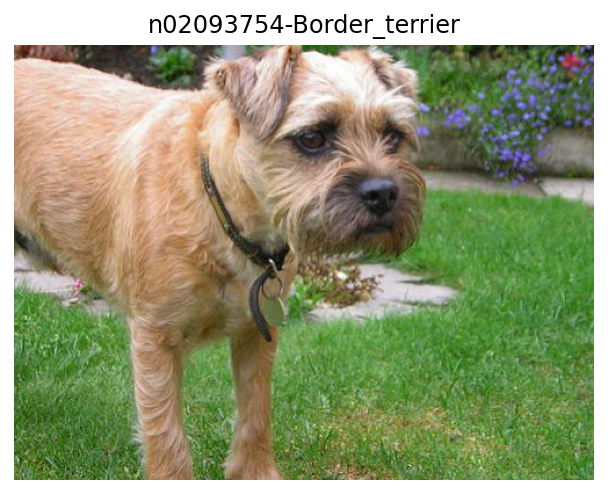

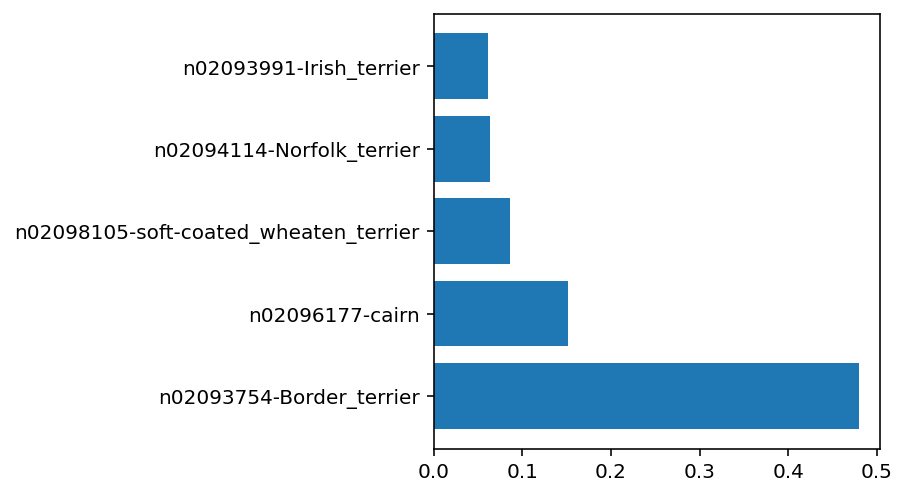

In [ ]:
img_path = 'Validation/n02093754-Border_terrier'+'/n02093754_1722.jpg'
x_pos, y_pos = predict(img_path, model, topk=5)
 
ax_img = imshow(process_image(img_path))
ax_img.set_title(y_pos[0])
print( np.exp(x_pos[0].to('cpu')))
ax_img.axis('off')
 
plt.figure(figsize=(4,4))
plt.barh(range(len(y_pos)), np.exp(x_pos[0].to('cpu')))
plt.yticks(range(len(y_pos)), y_pos)
 
plt.show()

In [ ]:
# # TODO: Do validation on the test set
 
correct = 0
total = 0
 
model.eval()
with torch.no_grad():
    for images, labels in train_dataloader: 
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
 
 
print("Test accuracy is: "+"{:.2%}".format(correct / total))
# print('Test accuracy is {}'.format(correct / total));

Test accuracy is: 80.94%


In [ ]:
train_datasets.class_to_idx


In [ ]:
model = models.resnet50(pretrained=True)
optimizer = optim.Adam(model.fc.parameters(),lr=0.001)
 
 
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model.fc = nn.Sequential(OrderedDict([
                          ('dropout',nn.Dropout(checkpoint['dropout'])),
                          ('fc1',nn.Linear(2048,checkpoint['hidden_units'][0])),
                          ('relu',nn.ReLU()),
                          ('fc2',nn.Linear(checkpoint['hidden_units'][0],checkpoint['hidden_units'][1])),
                          ('relu2',nn.ReLU()),
                          ('fc3',nn.Linear(checkpoint['hidden_units'][1],checkpoint['hidden_units'][2])),
                          ('relu3',nn.ReLU()),
                          ('fc4',nn.Linear(checkpoint['hidden_units'][2],checkpoint['output_size'])),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
    optimizer = checkpoint['optimzer_state']
    # print(checkpoint['state_dict'])
    
                           
    model.fc.load_state_dict(checkpoint['state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']
  
    
    
    
    return model,optimizer
 
model,optimizer.state_dict = load_checkpoint(data_dir +'/drive/MyDrive/checkpoint_dog_breed_classifier.pth')
model.to(device)
print(model.fc.state_dict)
# for var_name in optimizer.state_dict():
#     print(var_name, "\t", optimizer.state_dict()[var_name])
# for param_tensor in model.state_dict():
#     print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

<bound method Module.state_dict of Sequential(
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=2048, out_features=480, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=480, out_features=80, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=80, out_features=240, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=240, out_features=120, bias=True)
  (output): LogSoftmax(dim=1)
)>
